<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Transformers Inference

by Fabian Märki

## Summary
The aim of this notebook is to show how to use Huggingface sequence classification model.


## Links
- [Quick Tour](https://huggingface.co/docs/transformers/quicktour) on how to use huggingface transformers
- [Course](https://huggingface.co/course/chapter1) on how to use Huggingface's transformer models (from simple using pipelines to complex implementing the training loop).
- [Model](bert-base-multilingual-uncased-sentiment) used in this notebook


<a href="https://colab.research.google.com/github/markif/2022_HS_DAS_NLP_Notebooks/blob/master/08_b_Transformers_Text_Classifier_Inference.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.4.8,<0.5.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download

import numpy as np
import pandas as pd

import tensorflow as tf

**Make sure that a GPU is available (see [here](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm))!!!**

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.15.0-48-generic
Python version: 3.8.10
CPU cores: 6
RAM: 31.12GB total and 23.44GB available
Tensorflow version: 2.10.0
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


In [3]:
%%time
download("https://drive.google.com/uc?id=19AFeVnOfX8WXU4_3rM7OFoNTWWog_sb_", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

CPU times: user 12.5 s, sys: 1.69 s, total: 14.2 s
Wall time: 10.2 s


In [4]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [5]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


In [6]:
%%capture

!pip install transformers

In [7]:
def get_compute_device():
    """Provides the device for the computation
    
    Returns
    -------
    str
        The GPU device with number (cuda:0) or cpu
    """
    
    import torch

    return "cuda:0" if torch.cuda.is_available() else "cpu"


def gpu_empty_cache():
    """Cleans the GPU cache which seems to fill up after a while
    
    """
    
    import torch
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [8]:
params = {
    "verbose": True,
    "shuffle": True,
    # modify batch_size in case you experience memory issues
    "batch_size": 16,
    "X_column_name": "text_clean",
    "y_column_name": "label",
    "y_column_name_prediction": "prediction",
    "compute_device": get_compute_device(),
    "last_stored_batch": -1,
}

In [9]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
compute_device = get_compute_device()

# use_fast=True selects the fast tokenizer which is available for almost all models   
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(compute_device)

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [10]:
def predict(params, texts):
    """Computes the prediction from a list of text

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    texts: list
        The list of texts
        
    Returns
    -------
    list
        The predictions
    """
    import torch
        
    input_sequence_length = params.get("input_sequence_length", 256)
    compute_device = params.get("compute_device", "cpu")
    
    batch = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=input_sequence_length,
            return_tensors="pt",
        ).to(compute_device)
    outputs = model(**batch)

    # predicts a 5 star rating
    predictions = torch.nn.functional.softmax(outputs.logits, dim=1)
    _, predictions = torch.max(predictions, 1)
    
    return ["positive" if pred >= 2 else "negative" for (idx,pred) in enumerate(predictions)]

In [11]:
predict(params, data[params["X_column_name"]].head(3).tolist())

['positive', 'negative', 'positive']

In [12]:
def compute_predictions(params, data, predict_func):
    """Computes the actual predictions. Allows for recovery in case of a crash...

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    data: dataframe
        The data
    predict_func: callable
        The function that computes the prediction
    """
    import os
    from datetime import datetime
    
    from fhnw.nlp.utils.storage import save_dataframe
    from fhnw.nlp.utils.storage import load_dataframe
    
    verbose = params.get("verbose", False)
    batch_size = params.get("batch_size", 8)
    X_column_name = params.get("X_column_name", "text")
    y_column_name = params.get("y_column_name", "label")
    y_column_name_prediction = params.get("y_column_name_prediction", "prediction")
    store_every_n_elements = params.get("store_every_n_elements", 32768)
    store_path = params.get("store_path", "data/predictions.parq")
    last_stored_batch = params.get("last_stored_batch", -1)
    empty_gpu_cache = params.get("empty_gpu_cache", False)
    
    predictions = []
    
    # load stored data for recovery
    if last_stored_batch >= 0 or last_stored_batch == -1 and os.path.exists(store_path):
        predictions_loaded = load_dataframe(store_path)
        predictions = [row.to_dict() for index, row in predictions_loaded.iterrows()]
        
        if last_stored_batch < 0:
            last_stored_batch = len(predictions) // batch_size
            
        if verbose:
            print(datetime.now().time(), "Loaded batch:", last_stored_batch, " predictions: ", len(predictions))
         
    # do the predictions
    for g, df in data.groupby(np.arange(len(data)) // batch_size):
        if g >= last_stored_batch:
            # prevent OOM on GPU
            if empty_gpu_cache:
                gpu_empty_cache()
                
            predictions_batch = predict_func(params, df[X_column_name].to_list())
            
            # store the predictions together with the data
            i = 0
            for index, row in df.iterrows():
                # e.g. back translation might provide more than one translation per prediction
                if isinstance(predictions_batch[i], list):
                    for prediction in predictions_batch[i]:
                        row_dict = row.to_dict()
                        row_dict[y_column_name_prediction] = prediction
                        predictions.append(row_dict)
                else:
                    row_dict = row.to_dict()
                    row_dict[y_column_name_prediction] = predictions_batch[i]
                    predictions.append(row_dict)

                i += 1

                
            if (g + 1) % (store_every_n_elements // batch_size) == 0:
                if verbose:
                    print(datetime.now().time(), "Save batch:", str(g+1), ", processed elements:", str((g+1)*batch_size), ", total predictions:", len(predictions))

                save_dataframe(pd.DataFrame(predictions), store_path)

    if verbose:
        print(datetime.now().time(), "Prediction done. Batches:", str(data.shape[0] // batch_size), ", processed elements:", str(data.shape[0]), ", total predictions:", len(predictions))
    
    pred_data = pd.DataFrame(predictions)
    save_dataframe(pred_data, store_path)
    
    return pred_data

In [13]:
%%time

pred_data = compute_predictions(params, data, predict)

05:25:29.430580 Loaded batch: 20699  predictions:  331187
05:25:29.852595 Prediction done. Batches: 20699 , processed elements: 331187 , total predictions: 331190
CPU times: user 1min 33s, sys: 2.67 s, total: 1min 35s
Wall time: 1min 32s


In [14]:
def report_classification_results(params, y, y_pred):
    """Reports all classification results

    Parameters: 
        params: dict
            The dictionary containing the parameters
        y: list
            The true labels
        y_pred: list
            The predicted labels
    """
    
    import os
    from sklearn.metrics import classification_report
    from fhnw.nlp.utils.ploting import plot_confusion_matrix
    
    verbose = params.get("verbose", False)
    path = params.get("model_path")
    
    if path is not None:
        path_confusion_matrix = os.path.join(path, "confusion_matrix.png")
        plot_confusion_matrix(y, y_pred, filename=path_confusion_matrix)
    if verbose:
        plot_confusion_matrix(y, y_pred)
        
    if path is not None:
        path_classification_report = os.path.join(path, "classification_report.csv")
        report = classification_report(y, y_pred, output_dict=True)
        report = pandas.DataFrame(report).transpose()
        report.to_csv(path_classification_report)
    if verbose:
        report = classification_report(y, y_pred)
        print(report)

Set Population: 331190
Accuracy: 0.9593


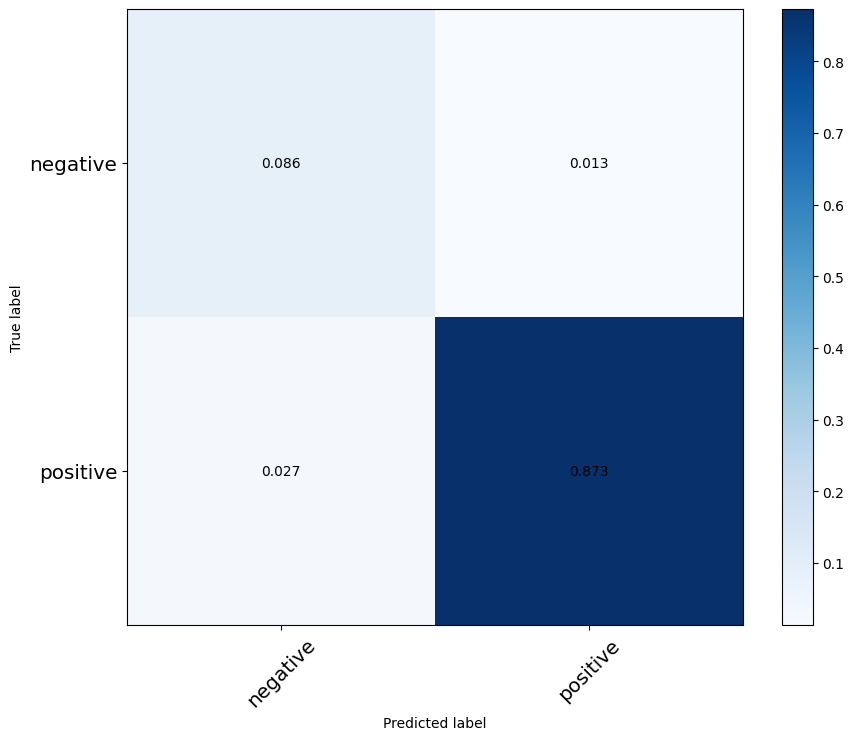

              precision    recall  f1-score   support

    negative       0.76      0.87      0.81     33022
    positive       0.98      0.97      0.98    298168

    accuracy                           0.96    331190
   macro avg       0.87      0.92      0.89    331190
weighted avg       0.96      0.96      0.96    331190



In [15]:
report_classification_results(params, pred_data[params["y_column_name"]].to_list(), pred_data[params["y_column_name_prediction"]].to_list())